In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import random
import sys
import pandas as pd
if '/opt/ros/kinetic/lib/python2.7/dist-packages' in sys.path:
    sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
import cv2
import numpy as np
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
if sys.version_info[0] == 2:
    import xml.etree.cElementTree as ET
else:
    import xml.etree.ElementTree as ET
from matplotlib import pyplot as plt

In [21]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [22]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [23]:
batch_size = 25
epochs     = 60 #500
lr         = 1e-4
momentum   = 0
w_decay    = 1e-5
step_size  = 17
gamma      = 0.5
model_use  = "barcode" # "products_20" "mini_competition"
n_class = 2

In [24]:
# get data
data_dir  = os.path.join("data", model_use)
if not os.path.exists(data_dir):
    print("Data not found!")
# create dir for model
model_dir = os.path.join("models", model_use)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
# create dir for score
score_dir = os.path.join("scores", model_use)
if not os.path.exists(score_dir):
    os.makedirs(score_dir)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = UNet(n_channels=3, n_classes=n_class - 1)
net.to(device=device)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=

In [31]:
means     = np.array([103.939, 116.779, 123.68]) / 255. # mean of three channels in the order of BGR
h, w      = 64, 64
val_h     = h
val_w     = w

class product_dataset(Dataset):

    def __init__(self, txt_file, phase, n_class=n_class, flip_rate=0.):
        
        self.data      = pd.read_csv(txt_file,header=None)
        self.means     = means
        self.n_class   = n_class
        self.flip_rate = flip_rate
        if phase == 'train':
            self.flip_rate = 0.5

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        name = self.data.iloc[idx,0]
#         print (name)
        img  = cv2.imread(os.path.join(data_dir, "Images", name) + ".jpg",cv2.IMREAD_UNCHANGED)
        xml_name = os.path.join(data_dir, "Annotations", name) + ".xml"
#         if random.random() < self.flip_rate:
#             img   = np.fliplr(img)
#             label = np.fliplr(label)

        mask = np.zeros([480, 640], dtype = np.uint8)
    
        target = ET.parse(xml_name).getroot()
        for obj in target.iter('object'):
            polygons = obj.find('polygon')
            if obj.find('name').text.lower().strip() != "barcode":
                continue

            x = []
            y = []
            bndbox = []
            poly_vertice = []
            for polygon in polygons.iter('pt'):
                poly_vertice.append([int(polygon.find('x').text), int(polygon.find('y').text)])
                # scale height or width
                x.append(int(polygon.find('x').text))
                y.append(int(polygon.find('y').text))
            min_x = min(x) - 5 if min(x) - 5 > 0 else 0
            min_y = min(y) - 5 if min(y) - 5 > 0 else 0
            max_x = max(x) + 5 if max(x) + 5 < 640 else 640
            max_y = max(y) + 5 if max(y) + 5 < 480 else 480
            
            bndbox.append(min_x)
            bndbox.append(min_y)
            bndbox.append(max_x)
            bndbox.append(max_y)
            poly_vertice = np.array(poly_vertice, np.int32)
            
#         print (bndbox)
        cv2.fillConvexPoly(mask, poly_vertice, 1)
        
        label = mask[bndbox[1]:bndbox[3],bndbox[0]:bndbox[2]].copy()
        origin_img = img[bndbox[1]:bndbox[3],bndbox[0]:bndbox[2]].copy()
        label = cv2.resize(label, (64, 64))
        origin_img = cv2.resize(origin_img, (64, 64))
        
        img = origin_img.copy()
        # reduce mean
        img = img[:, :, ::-1]  # switch to BGR
        
        img = np.transpose(img, (2, 0, 1)) / 255.
        img[0] -= self.means[0]
        img[1] -= self.means[1]
        img[2] -= self.means[2]

        # convert to tensor
        img = torch.from_numpy(img.copy()).float()
        label = torch.from_numpy(label.copy()).long()

        # create one-hot encoding
        h, w = label.size()
        target = torch.zeros(1, h, w)
        
        target[0][label == 1] = 1
#         target[1][label == 1] = 1
        
        
#         plt.figure()
#         plt.imshow(origin_img)
#         plt.show()
#         plt.figure()
#         plt.imshow(label)
#         plt.show()        
 
        sample = {'X': img, 'Y': target, 'l': label, 'origin': origin_img}

        return sample

In [32]:
# initial dataloader for trainning and validation
train_file = "/home/andyser/code/ML_related/unet/data/barcode/ImageSets/Main/train.txt"
val_file   = "/home/andyser/code/ML_related/unet/data/barcode/ImageSets/Main/test.txt"
train_data = product_dataset(txt_file = train_file, phase = 'train')
val_data   = product_dataset(txt_file = val_file, phase = 'val', flip_rate = 0)
dataloader = DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers = 0)
val_loader = DataLoader(val_data, batch_size = 4, num_workers = 0)

# dataiter = iter(val_loader)

# define loss function
optimizer = optim.RMSprop(net.parameters(), lr=lr, weight_decay=1e-8)
if net.n_classes > 1:
    criterion = nn.CrossEntropyLoss()
else:
    criterion = nn.BCEWithLogitsLoss()
# decay LR by a factor of 0.5 every step_size = 50 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size = step_size, gamma = gamma)  

In [33]:
for epoch in range(epochs):
    net.train()
    scheduler.step()
    epoch_loss = 0

    for _iter, batch in enumerate(dataloader):
        imgs = batch['X']
        true_masks = batch['Y']

        imgs = imgs.to(device=device, dtype=torch.float32)
        true_masks = true_masks.to(device=device, dtype=torch.float32)

        masks_pred = net(imgs)
        loss = criterion(masks_pred, true_masks)
        epoch_loss += loss.item()
        print (loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        
    configs    = "UNet_epoch{}_loss{:.4f}".format(epoch, loss.item())
    model_path = os.path.join(model_dir, configs)        
    torch.save(net.state_dict(), model_path + '.pkl')

1.7714899778366089
1.6979241371154785
1.0618808269500732
0.6134244203567505
0.4405744969844818
0.3213976323604584
0.3360375165939331
0.3698095679283142
0.25218841433525085
0.21612991392612457
0.2077145129442215
0.19058755040168762
0.23201945424079895
0.21025583148002625
0.22567786276340485
0.20194002985954285


KeyboardInterrupt: 

In [34]:
dataiter = iter(val_loader)

In [41]:
def prediction(model_name):
    # load pretrain models
    state_dict = torch.load(os.path.join(model_dir, model_name))
    net.load_state_dict(state_dict)
    net.eval()
    
    batch = dataiter.next()
    inputs = batch['X'].to(device=device, dtype=torch.float32)

    img    = batch['origin']
    label  = batch['l']
    
    output = net(inputs)
    output = output.data.cpu().numpy()

    N, _, h, w = output.shape
    
    pred = output.transpose(0, 2, 3, 1).reshape(-1, n_class - 1).reshape(N, h, w)
    pred[pred < 0] = 0 
    pred[pred > 0] = 1 
    # show images
    plt.figure(figsize = (10, 12))
    img = img.numpy()
    for i in range(N):
        img[i] = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)
        plt.subplot(N, 3, i*3 + 1)
        plt.title("origin_img")
        plt.imshow(img[i])
        #print(np.unique(_img[i]))

        plt.subplot(N, 3, i*3 + 2)
        plt.title("label_img")
        plt.imshow(label[i],cmap = "brg",vmin = 0, vmax = n_class - 1)

        plt.subplot(N, 3, i*3 + 3)
        plt.title("prediction")
        plt.imshow(pred[i],cmap = "brg",vmin = 0, vmax = n_class - 1)

    plt.show()

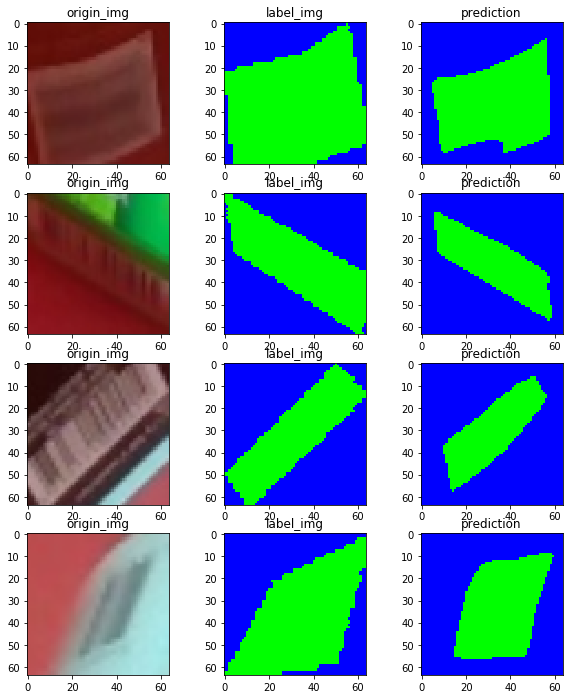

In [44]:
prediction("UNet_epoch54_loss0.0285.pkl")